In [1]:
from __future__ import division
import os
import numpy as np
import pprint
import tensorflow as tf
import tensorflow.contrib.slim as slim
import pickle, csv
import sys
import time
import datetime
#import nilearn
import nibabel as nib
from scipy.ndimage.morphology import binary_dilation
sys.path.append('..')
from utils import *
from model import UNet3D
#
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Project dir
proj_dir = '/Users/nikhil/code/git_repos/skull_seg/'

# Model training

In [3]:
# FLAGS
flags = tf.app.flags
flags.DEFINE_integer("epoch", 1, "Epoch to train [4]")
flags.DEFINE_string("train_patch_dir", proj_dir + "sample_data/patches/p32/", "Directory of the training data [patches]")
flags.DEFINE_bool("split_train", False, "Whether to split the train data into train and val [False]")
flags.DEFINE_string("train_data_dir", proj_dir + "sample_data/input/", "Directory of the train data [../BraTS17TrainingData]")
flags.DEFINE_string("deploy_data_dir", proj_dir + "sample_data/input/", "Directory of the test data [../BraTS17ValidationData]")
flags.DEFINE_string("deploy_output_dir", proj_dir + "sample_data/predictions/", "Directory name of the output data [output]")
# flags.DEFINE_string("train_csv", "../BraTS17TrainingData/survival_data.csv", "CSV path of the training data")
# flags.DEFINE_string("deploy_csv", "../BraTS17ValidationData/survival_evaluation.csv", "CSV path of the validation data")
flags.DEFINE_integer("batch_size", 10, "Batch size [1]")
flags.DEFINE_integer("seg_features_root", 16, "Number of features in the first filter in the seg net [48]")
# flags.DEFINE_integer("survival_features", 8, "Number of features in the survival net [16]")
flags.DEFINE_integer("conv_size", 3, "Convolution kernel size in encoding and decoding paths [3]")
flags.DEFINE_integer("layers", 3, "Encoding and deconding layers [3]")
flags.DEFINE_string("loss_type", "dice", "Loss type in the model [cross_entropy]")
flags.DEFINE_float("dropout", 0.5, "Drop out ratio [0.5]")
flags.DEFINE_string("checkpoint_dir", "checkpoint", "Directory name to save the checkpoints [checkpoint]")
flags.DEFINE_string("log_dir", "logs", "Directory name to save logs [logs]")
flags.DEFINE_boolean("train", True, "True for training, False for deploying [False]")
flags.DEFINE_boolean("run_seg", True, "True if run segmentation [True]")
flags.DEFINE_boolean("run_survival", False, "True if run survival prediction [True]")

flags.DEFINE_string('f', '', 'kernel') # Needed for jupyter to work 
FLAGS = flags.FLAGS #flags.FLAGS

In [4]:
# pp = pprint.PrettyPrinter()
# pp.pprint(flags.FLAGS.__flags)

# Train
all_train_paths = []
# for dirpath, dirnames, files in os.walk(FLAGS.train_data_dir):
#     if os.path.basename(dirpath)[0:7] == 'Brats17':
#         all_train_paths.append(dirpath)

subject_dirs = next(os.walk(FLAGS.train_data_dir))[1]
for d in subject_dirs: 
    all_train_paths.append(os.path.join(FLAGS.train_data_dir,d))

training_paths = [os.path.join(FLAGS.train_patch_dir, name) for name in os.listdir(FLAGS.train_patch_dir)
                  if '.DS' not in name]
testing_paths = None

training_ids = [os.path.basename(i) for i in training_paths]
training_survival_paths = []
testing_survival_paths = None
training_survival_data = {}
testing_survival_data = None

if not os.path.exists(FLAGS.checkpoint_dir):
    os.makedirs(FLAGS.checkpoint_dir)

if not os.path.exists(FLAGS.log_dir):
    os.makedirs(FLAGS.log_dir)

In [5]:
start_time = datetime.datetime.now()
print(start_time)

test_network = False
if FLAGS.run_seg:
    run_config = tf.ConfigProto()
    with tf.Session(config=run_config) as sess:
    #with tf.Session() as sess:
    
        unet = UNet3D(sess, checkpoint_dir=FLAGS.checkpoint_dir, log_dir=FLAGS.log_dir, training_paths=training_paths,
                      testing_paths=testing_paths, batch_size=FLAGS.batch_size, layers=FLAGS.layers,
                      features_root=FLAGS.seg_features_root, conv_size=FLAGS.conv_size,
                      dropout=FLAGS.dropout, loss_type=FLAGS.loss_type)

        if FLAGS.train:
            model_vars = tf.trainable_variables()
            slim.model_analyzer.analyze_vars(model_vars, print_info=True)

            train_config = {}
            train_config['epoch'] = FLAGS.epoch

            train_metrics = unet.train(train_config)
        
        print('Training complete')
        
        if test_network:
            print('\nTesting trained model with actual MR image')
            if not os.path.exists(FLAGS.deploy_output_dir):
                os.makedirs(FLAGS.deploy_output_dir)

            unet.deploy(FLAGS.deploy_data_dir, FLAGS.deploy_output_dir)
            print('Test complete. Output at {}'.format(FLAGS.deploy_output_dir))
        
    tf.reset_default_graph()

end_time = datetime.datetime.now()
print('start: {}, end: {}'.format(start_time, end_time))

2018-11-12 10:51:31.673956
encoding...
encoding0
encoding1
encoding2
bottom
decoding...
decoding_conv2
decoding_conv1
decoding_conv0
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

---------
Variables: name (type shape) [size]
---------
encoding0/w1:0 (float32_ref 3x3x3x1x16) [432, bytes: 1728]
encoding0/b1:0 (float32_ref 16) [16, bytes: 64]
encoding1/w1:0 (float32_ref 3x3x3x16x32) [13824, bytes: 55296]
encoding1/b1:0 (float32_ref 32) [32, bytes: 128]
encoding2/w1:0 (float32_ref 3x3x3x32x64) [55296, bytes: 221184]
encoding2/b1:0 (float32_ref 64) [64, bytes: 256]
bottom/w1:0 (float32_ref 3x3x3x64x128) [221184, bytes: 884736]
bottom/b1:0 (float32_ref 128) [128, bytes: 512]
decoding_dconv2/w:0 (float32_ref 2x2x2x64x128) [65536, bytes: 262144]
decoding_conv2/w1:0 (float32_ref 3x3x3x64x64) [110592, bytes: 442368]
decoding_conv2/b1:0 (float32_ref 64) 

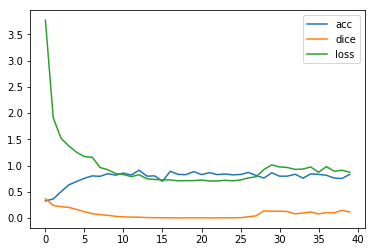

In [11]:
acc = np.array(train_metrics['acc'])
dice = np.array(train_metrics['dice'])
loss = np.array(train_metrics['loss'])

plt.plot(acc,label='acc')
plt.plot(dice,label='dice')
plt.plot(loss,label='loss')
plt.legend()